# Personal Information
Name: **Maarten Blom**

StudentID: **12877034**

Email: [**maarten.blom@student.uva.nl**](maarten.blom@student.uva.nl)

GITHUB:**maarten.blom@student.uva.nl** 

Submitted on: **22.03.2024**

# Data Context
The data used was found here: https://www.kaggle.com/code/ekami66/detailed-exploratory-data-analysis-with-python 

This is a curated dataset. Not much cleaning will need to be performed.


The goal is to find provenance in slides through the papers like this: 

slide1 is created from paper1

slide2 is created from paper2

paper1 refers to paper2

slide1 has provenance in slide 2

# Data Description

Each entry contains a scientific paper and its slides, stored both in XML and PDF format. 

The XML files contain the structure and the content of the documents, but does not include the images.

XML is easy tot work with, because it is very structured and the tags used is standardised.The PDF files are harder to work with. I will try this approach later.

### Imports

In [1]:
#!pip install tqdm

In [2]:
import re
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

### Data Loading

In [3]:
df = pd.DataFrame(columns = ['Paper', 'Slides'])

for folder_num in tqdm(range(5001)):
    paper = np.nan
    slides = np.nan
    folder_path = os.path.join("dataset", str(folder_num))
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tei.xml'):
            paper = ET.parse(os.path.join(folder_path, file_name))
        if file_name.endswith('.clean_tika.xml'):
            slides = ET.parse(os.path.join(folder_path, file_name))
            
    df.loc[folder_num] = [paper, slides]

100%|█████████████████████████████████████████████████████████████████████████████| 5001/5001 [00:48<00:00, 102.23it/s]


In [13]:
print("amount of rows with missing .xml files: ", len(df[df.isna().any(axis=1)]), "out of", len(df))
print("these will be dropped")
df = df.dropna()

amount of rows with missing .xml files:  25 out of 4984
these will be dropped


### Raw Text extraction

### Analysis 1: Paper text


First, get raw text. 

In [5]:
def get_content_from_paper(tree):
    text = ""
    for element in tree.iter():
        if element.tag == "{http://www.tei-c.org/ns/1.0}body":
            for sub_element in element.iter():
                if sub_element.tag is not None:
                    text += sub_element.text or ""
    return text
    
df.loc[:, "PaperContent"] = df.Paper.apply(get_content_from_paper)

Plot for length

Paper amount of characters Mean:  28948.222110754414


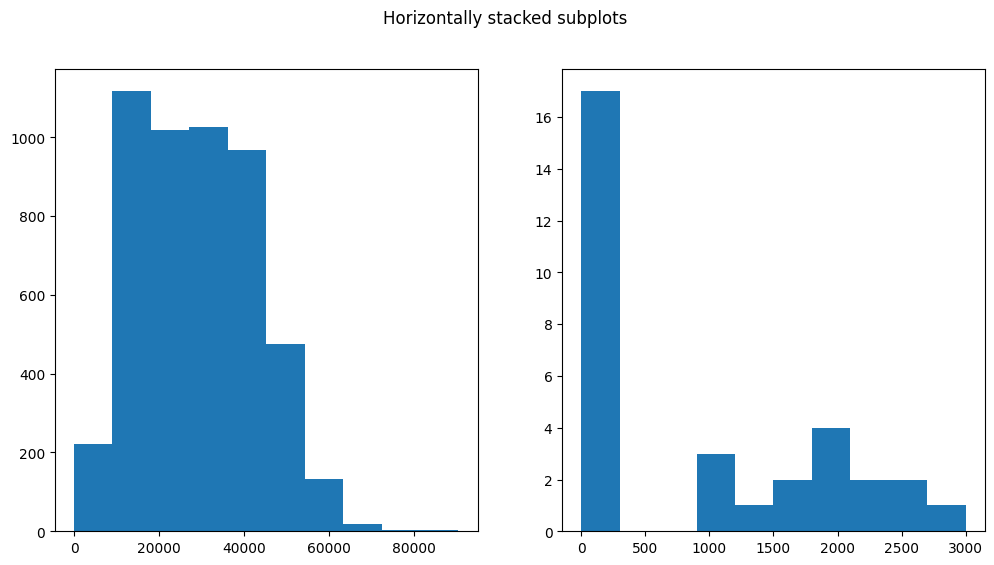

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Horizontally stacked subplots')
ax1.hist(df.PaperContent.apply(len))
ax2.hist(df.PaperContent.apply(len), range = (0, 3000))

print("Paper amount of characters Mean: ", df.PaperContent.apply(len).mean())

An avarage text document page is ~3000 characters long. A few documents in the dataset are lower than that. They will need to be looked at individualy.

In [7]:
print("Amount of documents with a suspiciously low charcter count: ", len(df[df["PaperContent"].str.len() < 3000]))

Amount of documents with a suspiciously low charcter count:  32


### Analysis 2: Slide text
The same analysis can be done for slides

In [8]:
def get_content_from_slides(tree):
    text = ""
    for element in tree.iter():
        if element.tag == "p":
            for sub_element in element.iter():
                if sub_element.tag is not None:
                    text += sub_element.text or ""
    return text
    
df.loc[:, "SlidesContent"] = df.Slides.apply(get_content_from_slides)

Paper amount of characters Mean:  8708.395465489566


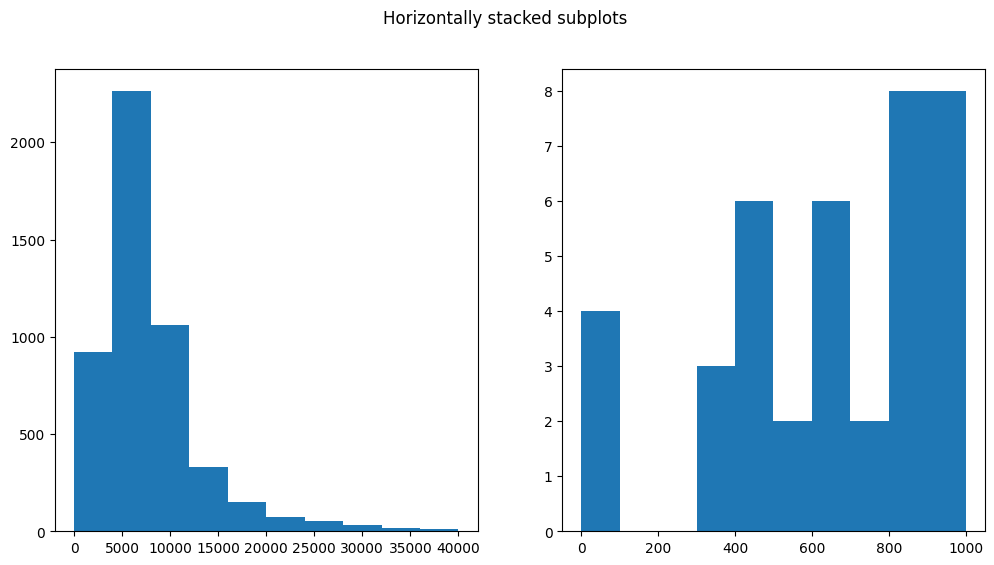

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Horizontally stacked subplots')
ax1.hist(df.SlidesContent.apply(len), range = (0, 40000))
ax2.hist(df.SlidesContent.apply(len), range = (0, 1000))

print("Paper amount of characters Mean: ", df.SlidesContent.apply(len).mean())

Some slides also have a suspiciously low character count. They will need to be looked at individualy.

In [10]:
print("Amount of documents with a suspiciously low charcter count: ", len(df[df["SlidesContent"].str.len() < 1000]))

Amount of documents with a suspiciously low charcter count:  39


### Analysis 3: Title and References
For provenance research, I need the title of the paper. I can use one of many API's to search for the paper and its references(I could also directly extract those just like I did the Title).

In [11]:
#{http://www.tei-c.org/ns/1.0}

def get_title(tree):
    for element in tree.iter():
        if element.tag == "{http://www.tei-c.org/ns/1.0}titleStmt":
            for sub_element in element.iter():
                if sub_element.tag == "{http://www.tei-c.org/ns/1.0}title":
                    return sub_element.text
    return None
df.loc[:, "Title"] = df.Paper.apply(get_title)

### Discussion
For a text-based approach, this is sufficcient. After looking at the suspicious documents, I can train a NLP model on either the raw text or the entirety of the XML code of the slide and the paper. 

I also want to include images found in the Paper and the Slides. These are not found in the XML files, but can be extracted from the PDF's. I've tried this, but havent been able to filter out the layout elements and the actual figures.

After finding the corrosponding paper to the slide, I can create a directed graph by linking the slides to the slides which its paper refers to. This is the goal that will be achieved.

In [ ]:
df